## Sub-analysis for Looking at Low and High Redshifts vs. Their Apparent Magnitude

In [1]:
import numpy as np
import sympy as sp
import astropy as ap
import astropy.units as u
import scipy as sci
import corner
import emcee as mc

from emcee import EnsembleSampler as es


from scipy import linalg as la
from scipy import optimize
from scipy import integrate
from scipy import stats

from sympy import Float as f
from sympy import limit as lim

from astropy.cosmology import WMAP9 as cosmo
from astropy import constants as const
from astropy.cosmology import LambdaCDM
from astropy.cosmology import wCDM



np.set_printoptions(threshold=np.inf)

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.sans-serif'] = 'stix'
matplotlib.rcParams['text.usetex'] = True
import matplotlib as mpl

In [2]:
def dataArray(data):
    ## creates an array of data given the column number (removes first term since the first row of the data file is the legend)
    
    ## columns(0-5): name(0), zcmb(1), zhel(2) dz(3), mb(4), dmb(5)
    ### Name: Target ID
    ### ZCMB: Redshift calculated in the frame of CMB
    ### ZHEL: Redshift calculated in the frame of the sun
    ### dZ: Error in spectroscopic redshifts (Note: they're technically not zero but they're so small they're basically negligible)
    ### MB: apparent magnitude
    ### dMB: error in apparent magnitude
    
    f = open('data.txt')
    array = []
    array = [x.split(' ')[data] for x in f.readlines()]
    array.pop(0)
    f.close()
    if str(data) == '0':
        return np.array(array)
    else:
        return np.array(array).astype(float)
    
fullDataArray = np.array([dataArray(0),dataArray(1).astype(float), dataArray(2).astype(float), dataArray(3).astype(float), dataArray(4).astype(float), dataArray(5).astype(float)])
fullDataArray = np.transpose(fullDataArray)


For this sub analysis, we are going to analyze what happens to the low and high redshifts of the data with respect to it's apparent magnitude. To do this, we will be finding the median of the data by separating the two redshifts equally, then we will be plotting the points on their own graphs. Once graphed, we will make conclusions about the analysis.

In [3]:
median_redshift = float(np.median(dataArray(2)))
high_redshift = np.zeros((1048,6))
low_redshift = np.zeros((1048,6))
for row in range(1048):
    for col in range(1,6):
        if dataArray(2)[row] >= median_redshift:
            high_redshift[row,col] = fullDataArray[row,col]
        elif dataArray(2)[row] <= median_redshift:
            low_redshift[row,col] = fullDataArray[row,col]
high_redshift = high_redshift[~(high_redshift==0).all(1)]
low_redshift = low_redshift[~(low_redshift == 0).all(1)]

Text(0.5, 1.0, 'High Redshift vs. Apparent Magnitude')

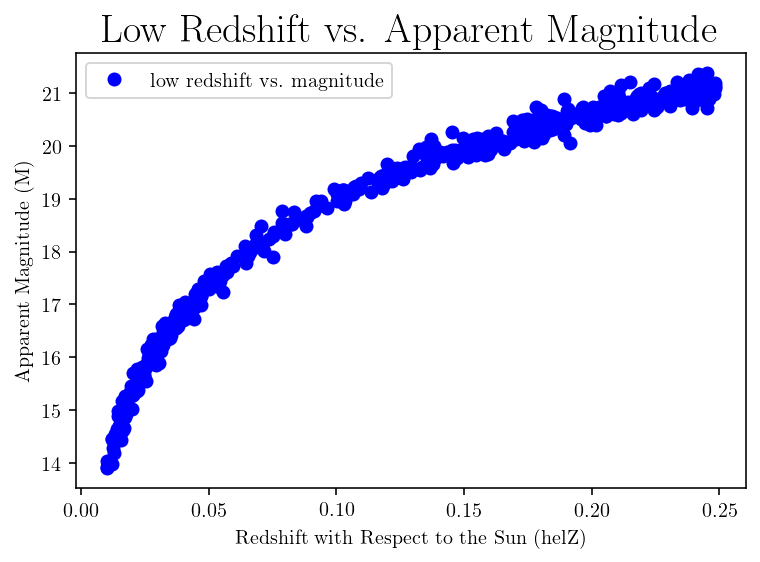

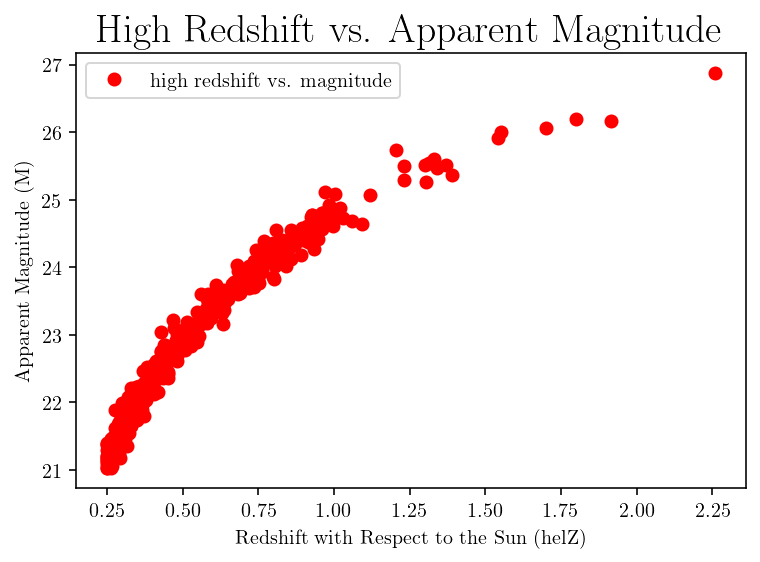

In [4]:
fig = plt.figure()
plt.plot(low_redshift[:,2], low_redshift[:,4], 'bo', linewidth = 2, label = 'low redshift vs. magnitude')
plt.legend(loc = 'best')
plt.xlabel('Redshift with Respect to the Sun (helZ)', fontsize = 10)
plt.ylabel('Apparent Magnitude (M)', fontsize = 10)
plt.title('Low Redshift vs. Apparent Magnitude', fontsize = 20)

fig = plt.figure()
plt.plot(high_redshift[:,2], high_redshift[:,4], 'ro', linewidth = 1, label = 'high redshift vs. magnitude')
plt.legend(loc = 'best')
plt.xlabel('Redshift with Respect to the Sun (helZ)', fontsize = 10)
plt.ylabel('Apparent Magnitude (M)', fontsize = 10)
plt.title('High Redshift vs. Apparent Magnitude', fontsize = 20)

In the code above, we can notice that the redshift is very dense in the low redshift region, the median being z = 0.25. This can be seen in the Sclonic et al. 2018 paper when it is discussed how there are different teams studying the low redshifts, and it seems there are a couple more studies on the low redshifts than the high redshifts. 

For the first graph, you can see how dense the line is and it has a similar shape to that of a square root function, or even parabolic. As the redshift is increasing, so too does the aparent magnitude, however it slows down approximately past z = 0.1. 

For the second graph, we can notice that the shape of the graph is very similar to the first, however it is not rising as quickly. An interesting thing to note is how after approximately z = 1.0, the density of the line dramatically decreases. This could be due to not observing as many SNe 1a past this redshift. 

For the conclusions of these graphs, we can say that these results do make sense. As the redshift gets higher, the luminosity of the star decreases as the wavelength gets stretched to lower frequencies below the optical. For the low redshifts, the magnitude is lower, making the SNe 1a appear brighter in the sky, and vice versa for the high redshift.

## Best Fit Analysis

Below, we will be using the same best fit analysis as in the main notebook, however values will be changed to acommodate the data for this analysis.

In [5]:
def dL_astropy_lambda( ΩM, ΩΛ, z, w ):
    dL = LambdaCDM(H0=70, Om0=ΩM, Ode0=ΩΛ)
    return dL.luminosity_distance(z).to_value(u.pc)

def μ_model_lambda(ΩM, ΩΛ, z, w ):
    μ = 5 * np.log10(dL_astropy_lambda(ΩM, ΩΛ, z, w)/10)
    return μ

def dL_astropy_omega( ΩM, ΩΛ, z, w ):
    dL = wCDM(H0=70, Om0=ΩM, Ode0=ΩΛ,w0=w)
    return dL.luminosity_distance(z).to_value(u.pc)

def μ_model_omega( ΩM, ΩΛ, z, w ):
    μ = 5 * np.log10(dL_astropy_omega( ΩM, ΩΛ, z, w )/10)
    return μ

## High Redshift Parameters

Here, we will be first focusing on defining the high redshift functions.

In [6]:
def ΛCDM_Χ_high(params):
    M = params[0]
    ΩM = params[1]
    ΩΛ = params[2]
    rs = high_redshift[:,2]
    m_data = high_redshift[:,4]
    dm = high_redshift[:,5]
    w = -1
    Χ_squared = np.sum((M + μ_model_lambda(ΩM, ΩΛ, rs, w ) - m_data)**2 / dm**2)
    return Χ_squared


def ωCDM_Χ_high(params):
    M = params[0]
    ΩM = params[1]
    ΩΛ = 1 - ΩM
    w = params[2]
    rs = high_redshift[:,2]
    m_data = high_redshift[:,4]
    dm = high_redshift[:,5]
    Χ_squared = np.sum((M + μ_model_omega(ΩM, ΩΛ, rs, w ) - m_data)**2 / dm**2)
    return Χ_squared

def opt_lambda_high(params):
    #M_avg = avg_abs_mag_lambda()
    M_avg = params[0]
    ΩM = params[1]
    ΩΛ = params[2]
    sol = optimize.fmin(ΛCDM_Χ_high, params, disp=0)#, retall=1)
    return sol

def opt_omega_high(params):
    M_avg = params[0]
    ΩM = params[1]
    ΩΛ = 1 - ΩM
    w = params[2]
    sol = optimize.fmin(ωCDM_Χ_high, params, disp = 0)
    #print(ΩΛ)
    return sol

## Low Redshift Parameters

Now, we will be defining the parameters for the low redshift.

In [7]:
def ΛCDM_Χ_low(params):
    M = params[0]
    ΩM = params[1]
    ΩΛ = params[2]
    rs = low_redshift[:,2]
    m_data = low_redshift[:,4]
    dm = low_redshift[:,5]
    w = -1
    Χ_squared = np.sum((M + μ_model_lambda(ΩM, ΩΛ, rs, w ) - m_data)**2 / dm**2)
    return Χ_squared


def ωCDM_Χ_low(params):
    M = params[0]
    ΩM = params[1]
    ΩΛ = 1 - ΩM
    w = params[2]
    rs = low_redshift[:,2]
    m_data = low_redshift[:,4]
    dm = low_redshift[:,5]
    Χ_squared = np.sum((M + μ_model_omega(ΩM, ΩΛ, rs, w ) - m_data)**2 / dm**2)
    return Χ_squared

def opt_lambda_low(params):
    #M_avg = avg_abs_mag_lambda()
    M_avg = params[0]
    ΩM = params[1]
    ΩΛ = params[2]
    sol = optimize.fmin(ΛCDM_Χ_low, params, disp=0)#, retall=1)
    return sol

def opt_omega_low(params):
    M_avg = params[0]
    ΩM = params[1]
    ΩΛ = 1 - ΩM
    w = params[2]
    sol = optimize.fmin(ωCDM_Χ_low, params, disp = 0)
    #print(ΩΛ)
    return sol

## Defining the Difference: High Redshift

We will once again separate and make different functions for each low and high redshifts, starting with high redshift.

In [8]:
def avg_abs_mag_lambda_high():
    ## determines average absolute magnitude for the ΛCDM model given approximate values of ΩM=0.3 and ΩΛ=0.7
    ## used to reduce bias in choosing initial conditions when minimizing χ2
    z = high_redshift[:,2]
    m = high_redshift[:,4]
    ΩM = 0.3
    ΩΛ = 0.7
    w = -1
    M_avg = np.sum(m - μ_model_lambda(ΩM, ΩΛ, z, w )) / np.sum(len(m)) 
    #M_avg = m[0] - μ_model(ΩM, ΩΛ, z, w )[0] ## potentially biased option
    return M_avg

def avg_abs_mag_omega_high():
    ## determines average absolute magnitude for the ωCDM model given approximate values of ΩM=0.3, ΩΛ=0.7, and w=-1
    ## used to reduce bias in choosing initial conditions when minimizing χ2
    z = high_redshift[:,2]
    m = high_redshift[:,4]
    ΩM = 0.3 #0.277
    ΩΛ = 0.7 #0.723
    w = -1 #-1.084
    M_avg = np.sum(m - μ_model_omega(ΩM, ΩΛ, z, w )) / np.sum(len(m))
    return M_avg

init_guess_lambda_high = [avg_abs_mag_lambda_high(), 0.3,0.7]
print('Lambda Optimize: ', opt_lambda_high(init_guess_lambda_high))

init_guess_omega_high = [avg_abs_mag_omega_high(),0.3, -1]
print('omega Optimize: ',opt_omega_high(init_guess_omega_high))

Lambda Optimize:  [-19.39521728   0.35448925   0.91305503]


omega Optimize:  [-19.43753616   0.35879929  -1.5488849 ]


## Defining the Difference: Low Redshift
Now we are going to look a the low redshifts.

In [9]:
def avg_abs_mag_lambda_low():
    ## determines average absolute magnitude for the ΛCDM model given approximate values of ΩM=0.3 and ΩΛ=0.7
    ## used to reduce bias in choosing initial conditions when minimizing χ2
    z = low_redshift[:,2]
    m = low_redshift[:,4]
    ΩM = 0.3
    ΩΛ = 0.7
    w = -1
    M_avg = np.sum(m - μ_model_lambda(ΩM, ΩΛ, z, w )) / np.sum(len(m)) 
    #M_avg = m[0] - μ_model(ΩM, ΩΛ, z, w )[0] ## potentially biased option
    return M_avg

def avg_abs_mag_omega_low():
    ## determines average absolute magnitude for the ωCDM model given approximate values of ΩM=0.3, ΩΛ=0.7, and w=-1
    ## used to reduce bias in choosing initial conditions when minimizing χ2
    z = high_redshift[:,2]
    m = high_redshift[:,4]
    ΩM = 0.3 #0.277
    ΩΛ = 0.7 #0.723
    w = -1 #-1.084
    M_avg = np.sum(m - μ_model_omega(ΩM, ΩΛ, z, w )) / np.sum(len(m))
    return M_avg

init_guess_lambda_low = [avg_abs_mag_lambda_low(), 0.3,0.7]
print('Lambda Optimize: ', opt_lambda_low(init_guess_lambda_low))

init_guess_omega_low = [avg_abs_mag_omega_low(),0.3, -1]
print('omega Optimize: ',opt_omega_low(init_guess_omega_low))

Lambda Optimize:  [-19.39923071   2.74944426   2.74075572]


omega Optimize:  [-19.40724715   0.67085558  -4.55176258]


## MCMC Analysis: High Redshift
As before, we are going to separate the low and high redshifts, starting with the high.

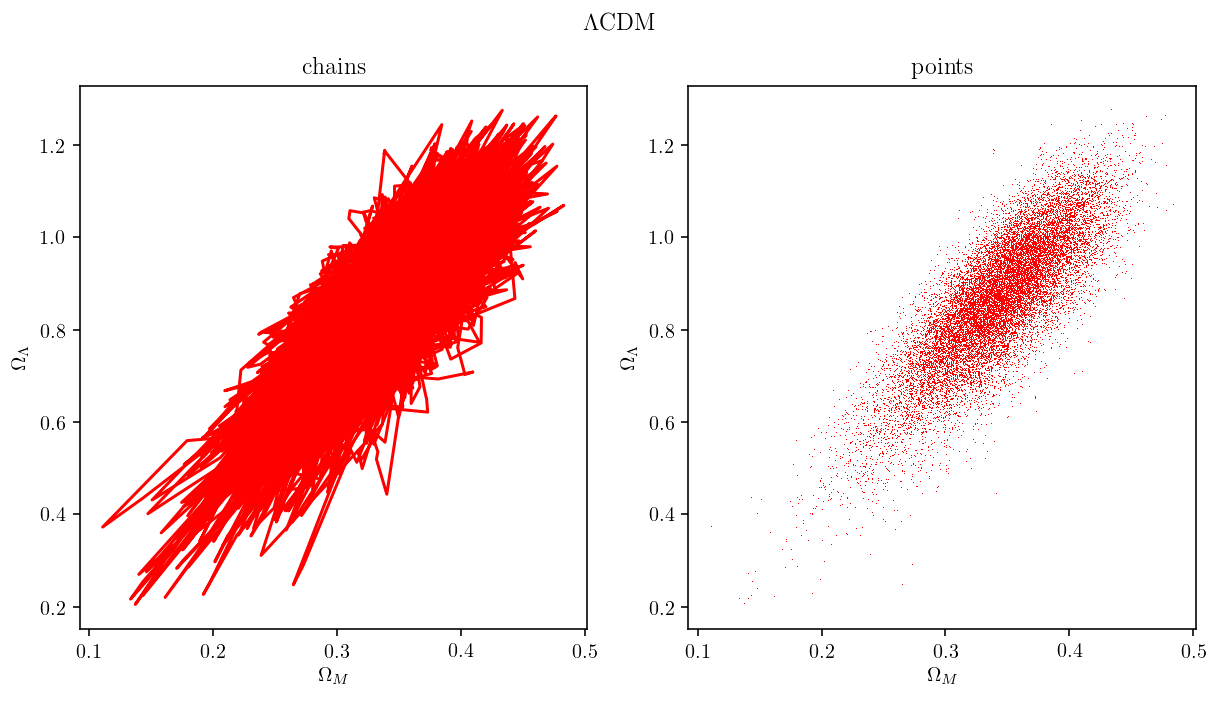

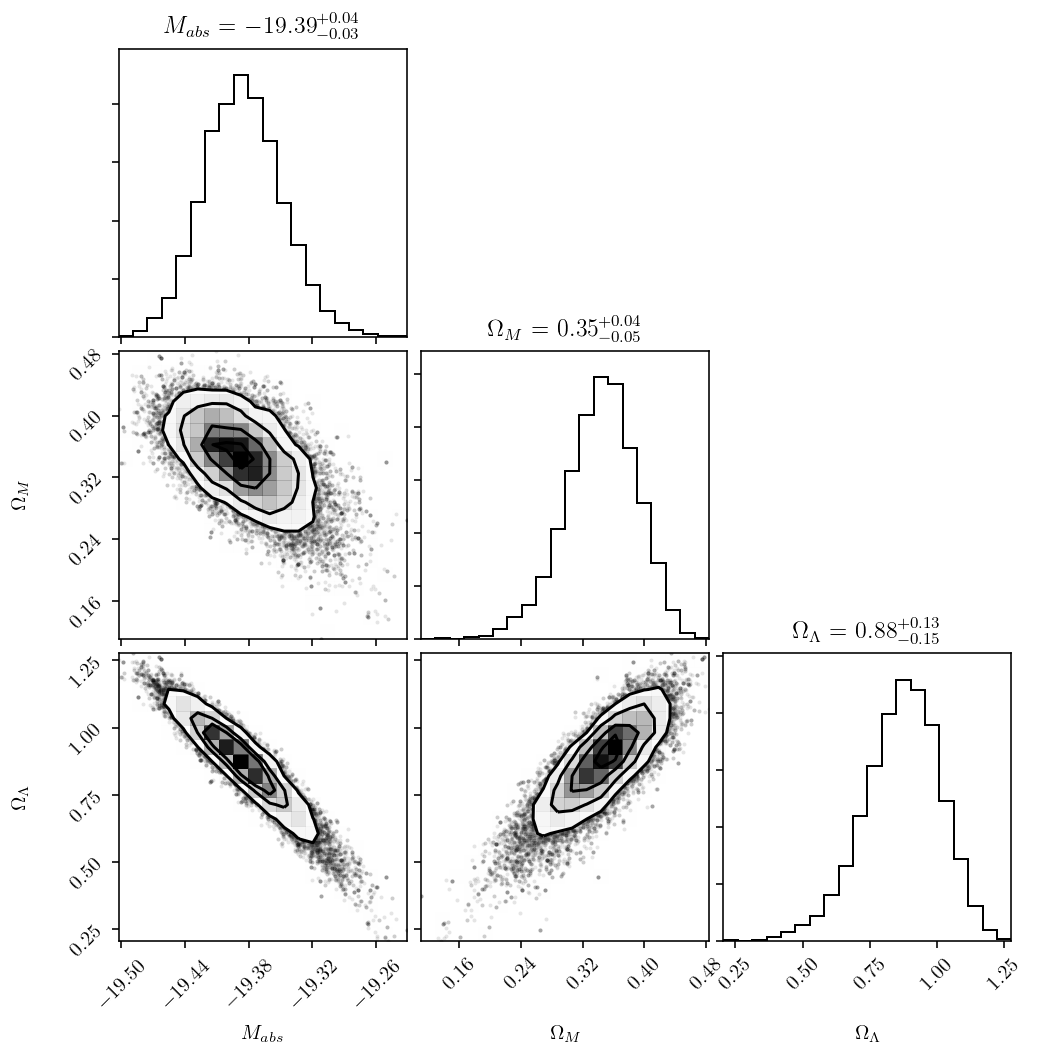

In [10]:
def lnprob_lambda_high(params):
    ## given the parameters of the ΛCDM model, constrains penalty function to within plausible values by returning the penalty only when
    ## the parameters meet the given conditions
    M = params[0]
    ΩM = params[1]
    ΩΛ = params[2]
    val = [M, ΩM, ΩΛ]
    #print(val)
    if M >= 0:
        return -np.inf
    elif ΩM <= 0:# or ΩM >= 0.5:
        return -np.inf
    elif ΩΛ <= 0:# or ΩΛ >= 1.5:
        return -np.inf
#     elif ΩM + ΩΛ >= 1.5:
#         return -np.inf
    else:
        return -0.5*ΛCDM_Χ_high(val)

ndim = 3 ## number of dimensions (parameters) being evaluated 
nwalk = 30 ## number of walkers being run
nburn = 500 ## number of steps to take in for burn in run
nmain = 1000 ## number of steps to take in main run

p0 = np.zeros((nwalk,ndim))
init_guess_lambda_high =[avg_abs_mag_lambda_high(), 0.3,0.7]
opt_lambda_high_val= opt_lambda_high(init_guess_lambda_high)

for i in range(nwalk):
    p0[i,0] = np.random.uniform(low=0, high=1e-8) + opt_lambda_high_val[0]
    p0[i,1] = np.random.uniform(low=0, high=1e-8) + opt_lambda_high_val[1]
    p0[i,2] = np.random.uniform(low=0, high=1e-8) + opt_lambda_high_val[2]

samp = es(nwalk,ndim,lnprob_lambda_high)

pos,prob,state = samp.run_mcmc(p0,nburn)

samp.reset()

res = samp.run_mcmc(pos,nmain)
samples_lambda = samp.chain.reshape((-1,ndim))

f,ax = plt.subplots(1,2,figsize=(10,5))
for iwalk in range(nwalk):
    ax[0].plot(samp.chain[iwalk,:,1],samp.chain[iwalk,:,2],'r')
    ax[1].plot(samp.chain[iwalk,:,1],samp.chain[iwalk,:,2],'r,')

ax[0].set_title('chains')
ax[1].set_title('points')
for i in range(0,2):
    ax[i].set_xlabel(r'$\Omega_{M}$')
    ax[i].set_ylabel(r'$\Omega_{\Lambda}$')
f.suptitle(r'$\Lambda$CDM')

f_lambda_high = corner.corner(samples_lambda,show_titles=True,labels=(r'$M_{abs}$',r'$\Omega_{M}$',r'$\Omega_{\Lambda}$'))


## MCMC Analysis: Low Redshift
After getting our random walk above for the high redshift, we will now use the low redshifts.

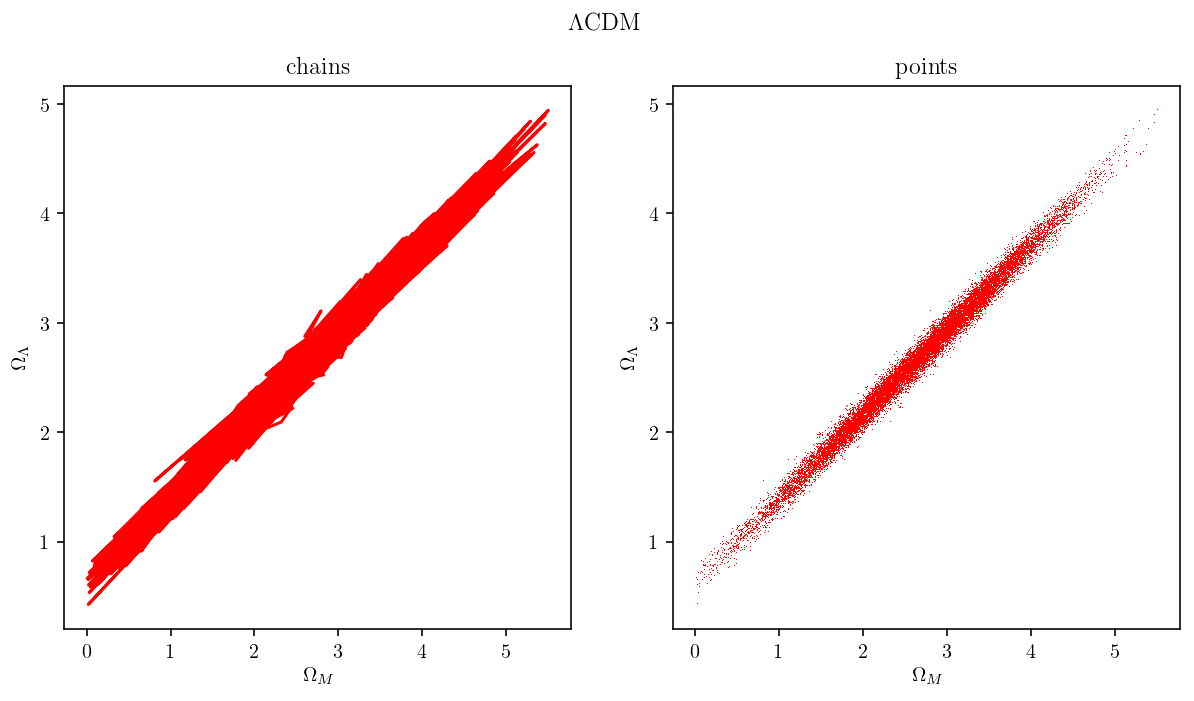

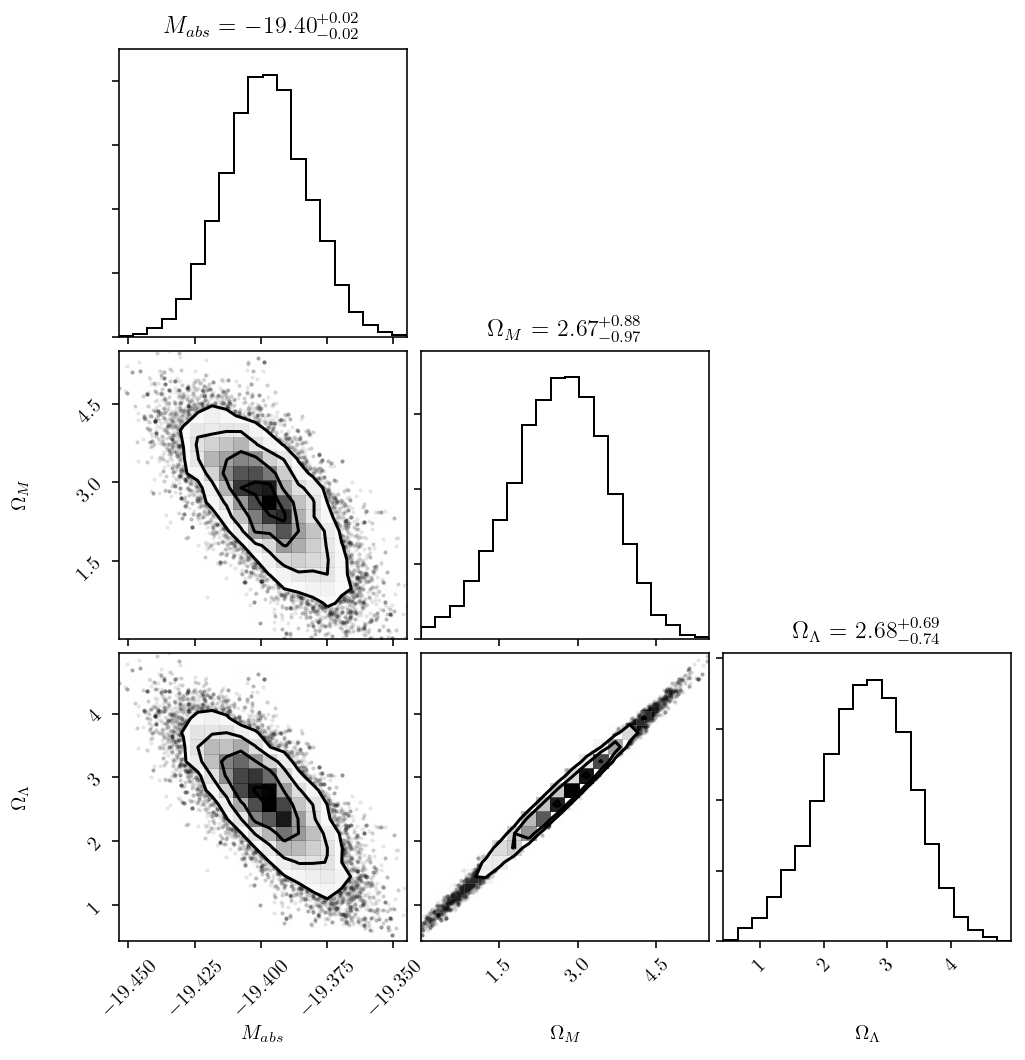

In [11]:
def lnprob_lambda_low(params):
    ## given the parameters of the ΛCDM model, constrains penalty function to within plausible values by returning the penalty only when
    ## the parameters meet the given conditions
    M = params[0]
    ΩM = params[1]
    ΩΛ = params[2]
    val = [M, ΩM, ΩΛ]
    #print(val)
    if M >= 0:
        return -np.inf
    elif ΩM <= 0:
        return -np.inf
    elif ΩΛ <= 0:
        return -np.inf
#     elif ΩM + ΩΛ <= 0 :
#         return -np.inf
    else:
        return -0.5*ΛCDM_Χ_low(val)

ndim = 3 ## number of dimensions (parameters) being evaluated 
nwalk = 30 ## number of walkers being run
nburn = 500 ## number of steps to take in for burn in run
nmain = 1000 ## number of steps to take in main run

p0 = np.zeros((nwalk,ndim))
init_guess_lambda_low =[avg_abs_mag_lambda_low(), 0.3,0.7]
opt_lambda_low_val= opt_lambda_low(init_guess_lambda_low)

for i in range(nwalk):
    p0[i,0] = np.random.uniform(low=0, high=1e-8) + opt_lambda_low_val[0]
    p0[i,1] = np.random.uniform(low=0, high=1e-8) + opt_lambda_low_val[1]
    p0[i,2] = np.random.uniform(low=0, high=1e-8) + opt_lambda_low_val[2]

samp = es(nwalk,ndim,lnprob_lambda_low)

pos,prob,state = samp.run_mcmc(p0,nburn)

samp.reset()

res = samp.run_mcmc(pos,nmain)
samples_lambda_low = samp.chain.reshape((-1,ndim))

f,ax = plt.subplots(1,2,figsize=(10,5))
for iwalk in range(nwalk):
    ax[0].plot(samp.chain[iwalk,:,1],samp.chain[iwalk,:,2],'r')
    ax[1].plot(samp.chain[iwalk,:,1],samp.chain[iwalk,:,2],'r,')

ax[0].set_title('chains')
ax[1].set_title('points')
for i in range(0,2):
    ax[i].set_xlabel(r'$\Omega_{M}$')
    ax[i].set_ylabel(r'$\Omega_{\Lambda}$')
f.suptitle(r'$\Lambda$CDM')

f_lambda_low = corner.corner(samples_lambda_low,show_titles=True,labels=(r'$M_{abs}$',r'$\Omega_{M}$',r'$\Omega_{\Lambda}$'))


## MCMC Analysis for omega CDM
Now we are going to move on to the second universe and look at the high and low redshifts in our MCMC analysis.

For high redshift:

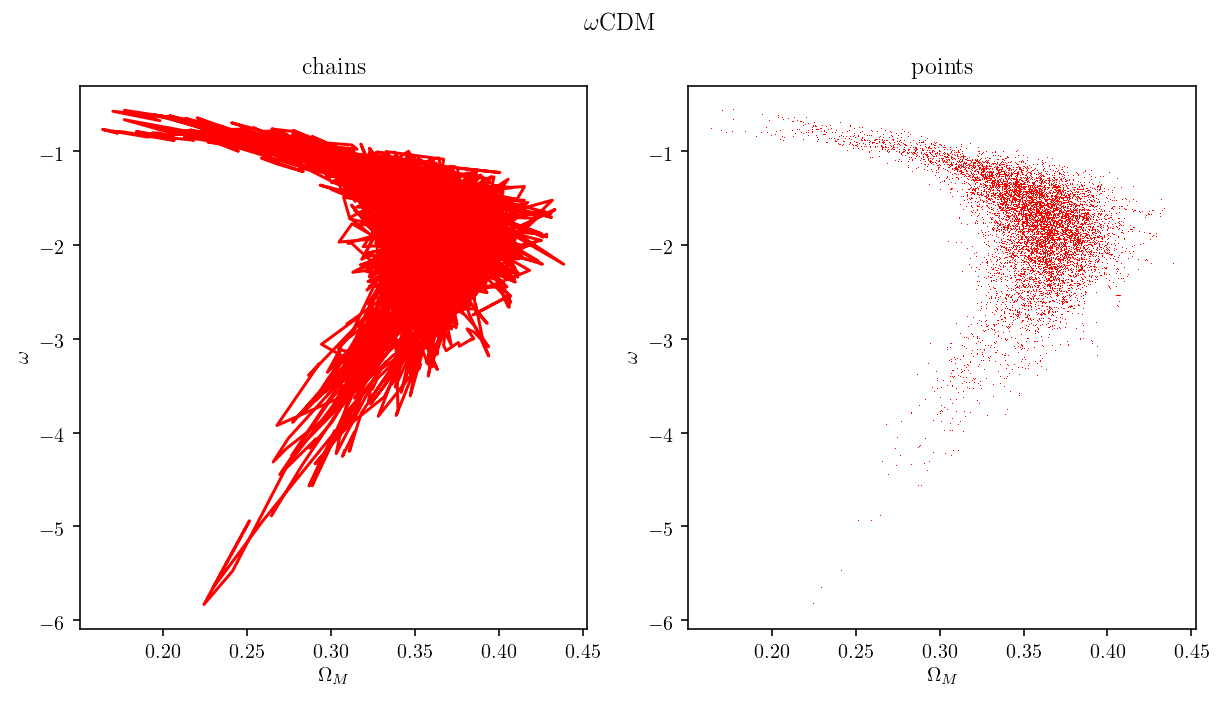

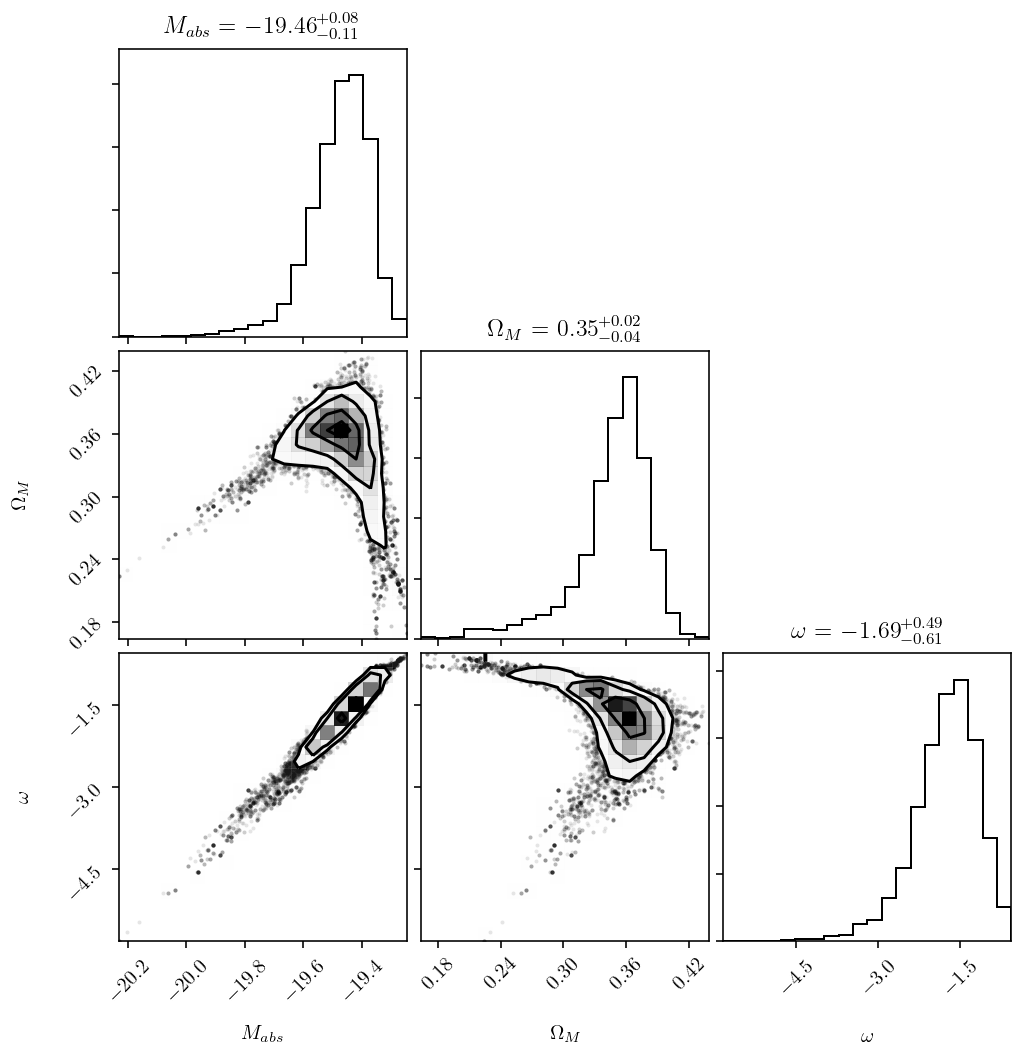

In [12]:
def lnprob_omega_high(params):
    ## given the parameters of the ωCDM model, constrains penalty function to within plausible values by returning the penalty only when
    ## the parameters meet the given conditions
    M = params[0]
    ΩM = params[1]
    ΩΛ = 1 - ΩM
    w = params[2]
    val = [M, ΩM, w]
    #print(val)

    if M >= 0:
        return -np.inf
    elif ΩM <= 0 or ΩM >= 0.5:
        return -np.inf
    elif ΩΛ <= 0 or ΩΛ >= 1:
        return -np.inf
    elif ΩM + ΩΛ >= 1.5:
        return -np.inf
    else:
        return -0.5*ωCDM_Χ_high(val)

ndim = 3 ## number of dimensions (parameters) being evaluated 
nwalk = 20 ## number of walkers being run
nburn = 500 ## number of steps to take in for burn in run
nmain = 1000 ## number of steps to take in main run

p0 = np.zeros((nwalk,ndim))
init_guess_omega_high =[avg_abs_mag_omega_high(), 0.3,0.7]
opt_omega_high= opt_omega_high(init_guess_omega_high)

for i in range(nwalk):
    p0[i,0] = np.random.uniform(low=0, high=1e-8) + opt_omega_high[0]
    p0[i,1] = np.random.uniform(low=0, high=1e-8) + opt_omega_high[1]
    p0[i,2] = np.random.uniform(low=0, high=1e-8) + opt_omega_high[2]

samp = es(nwalk,ndim,lnprob_omega_high)

pos,prob,state = samp.run_mcmc(p0,nburn)#,progress=True) ## burn in run

samp.reset()

res = samp.run_mcmc(pos,nmain)#,progress=True)  ## main run
samples_omega = samp.chain.reshape((-1,ndim)) 

f,ax = plt.subplots(1,2,figsize=(10,5))
for iwalk in range(nwalk):
    ax[0].plot(samp.chain[iwalk,:,1],samp.chain[iwalk,:,2],'r')
    ax[1].plot(samp.chain[iwalk,:,1],samp.chain[iwalk,:,2],'r,')

ax[0].set_title('chains')
ax[1].set_title('points')
for i in range(0,2):
    ax[i].set_xlabel(r'$\Omega_{M}$')
    ax[i].set_ylabel(r'$\omega$')
f.suptitle(r'$\omega$CDM')

f_omega_high = corner.corner(samples_omega,show_titles=True,labels=(r'$M_{abs}$',r'$\Omega_{M}$',r'$\omega$'))

Now we move onto low redshifts.

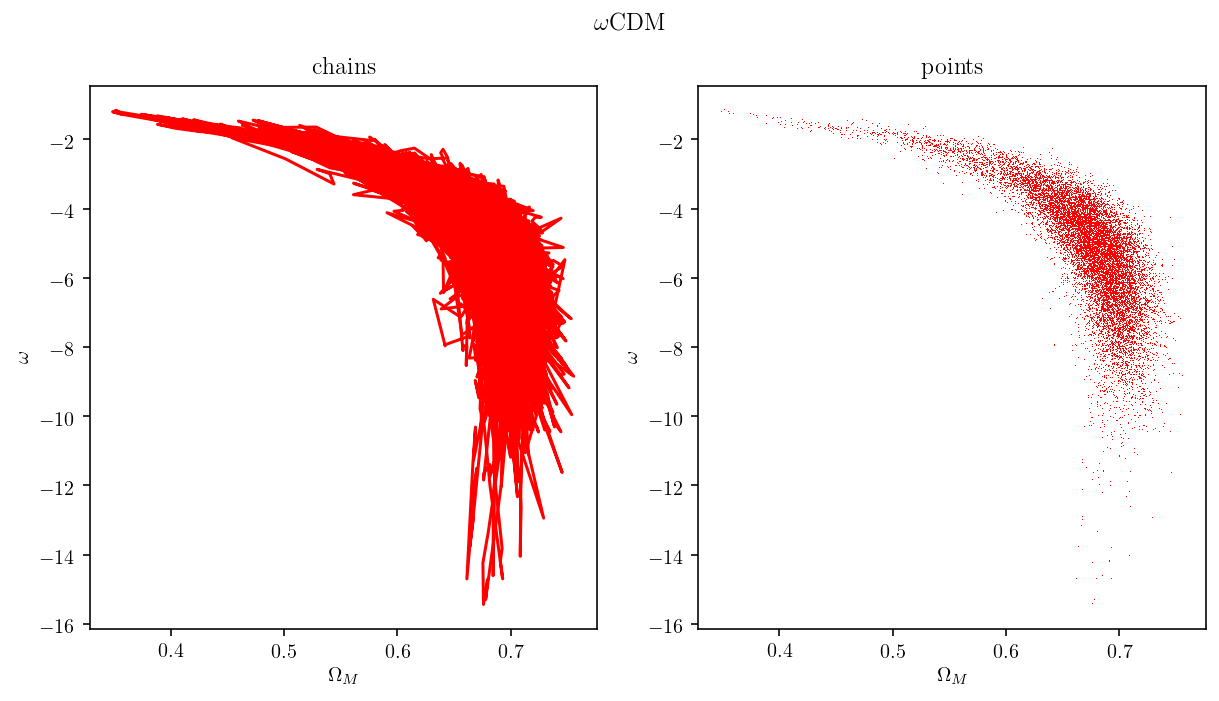

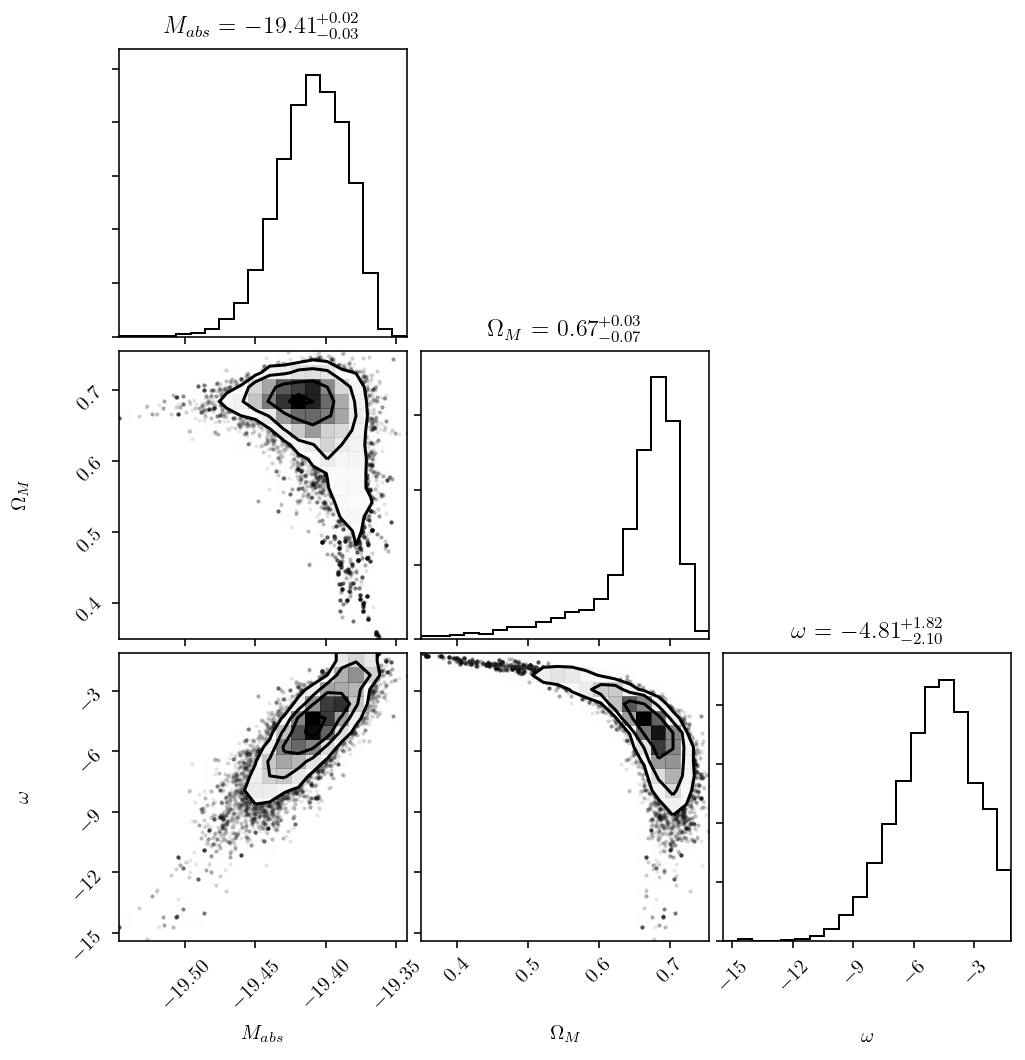

In [13]:
def lnprob_omega_low(params):
    ## given the parameters of the ωCDM model, constrains penalty function to within plausible values by returning the penalty only when
    ## the parameters meet the given conditions
    M = params[0]
    ΩM = params[1]
    ΩΛ = 1 - ΩM
    w = params[2]
    val = [M, ΩM, w]
    #print(val)
    if M >= 0:
        return -np.inf
    elif ΩM <= 0:
        return -np.inf
    elif ΩΛ <= 0:
        return -np.inf
    else:
        return -0.5*ωCDM_Χ_low(val)

ndim = 3 ## number of dimensions (parameters) being evaluated 
nwalk = 30 ## number of walkers being run
nburn = 500 ## number of steps to take in for burn in run
nmain = 1000 ## number of steps to take in main run

p0 = np.zeros((nwalk,ndim))
init_guess_omega_low =[avg_abs_mag_lambda_low(), 0.3,0.7]
opt_omega_low= opt_omega_low(init_guess_omega_high)

for i in range(nwalk):
    p0[i,0] = np.random.uniform(low=0, high=1e-8) + opt_omega_low[0]
    p0[i,1] = np.random.uniform(low=0, high=1e-8) + opt_omega_low[1]
    p0[i,2] = np.random.uniform(low=0, high=1e-8) + opt_omega_low[2]

samp = es(nwalk,ndim,lnprob_omega_low)

pos,prob,state = samp.run_mcmc(p0,nburn)#,progress=True) ## burn in run

samp.reset()

res = samp.run_mcmc(pos,nmain)#,progress=True)  ## main run
samples_omega = samp.chain.reshape((-1,ndim)) 

f,ax = plt.subplots(1,2,figsize=(10,5))
for iwalk in range(nwalk):
    ax[0].plot(samp.chain[iwalk,:,1],samp.chain[iwalk,:,2],'r')
    ax[1].plot(samp.chain[iwalk,:,1],samp.chain[iwalk,:,2],'r,')

ax[0].set_title('chains')
ax[1].set_title('points')
for i in range(0,2):
    ax[i].set_xlabel(r'$\Omega_{M}$')
    ax[i].set_ylabel(r'$\omega$')
f.suptitle(r'$\omega$CDM')

f_omega_low = corner.corner(samples_omega,show_titles=True,labels=(r'$M_{abs}$',r'$\Omega_{M}$',r'$\omega$'))

## Conclusions for Sub Analysis

For our MCMC analysis of the Lambda CDM, we notice that the high red shifts have higher error, but strangely, the low redshifts show that the universe has almost 4 times the amount of matter. The lower redshift is suggesting that there is more error than the higher redshift. This can hint to us that low redshifts could not be reliable.

For our Omega CDM, we see that the graphs are dramatically different compared to the original analysis. This could be due to systematics errors. We notice that once again the lower redshifts have higher error than the high redshifts.